In [3]:
!python --version


Python 3.11.8


In [4]:
# 🛠️ Step 1: Set up Spark Session
# Install pyspark if not already installed
%pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MallCustomersAnalysis").getOrCreate()

print("✅ Spark Session Created")
print(f"Spark Version: {spark.version}")

Note: you may need to restart the kernel to use updated packages.


your 131072x1 screen size is bogus. expect trouble
25/04/29 15:34:26 WARN Utils: Your hostname, HKCP resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/29 15:34:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/29 15:34:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session Created
Spark Version: 3.5.5


In [5]:
# Update the file path to the correct location of the dataset
df = spark.read.csv("/mnt/c/Users/hmdkr/DE-Projects/mall-customers/data/Mall_Customers.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()

+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows

root
 |-- CustomerID: integer (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [6]:
# 🛠️ 3. Basic EDA
print("✅ Summary Statistics:")
df.describe().show()

✅ Summary Statistics:


25/04/29 15:34:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------+-----------------+------------------+----------------------+
|summary|        CustomerID| Genre|              Age|Annual Income (k$)|Spending Score (1-100)|
+-------+------------------+------+-----------------+------------------+----------------------+
|  count|               200|   200|              200|               200|                   200|
|   mean|             100.5|  NULL|            38.85|             60.56|                  50.2|
| stddev|57.879184513951124|  NULL|13.96900733155888| 26.26472116527124|    25.823521668370173|
|    min|                 1|Female|               18|                15|                     1|
|    max|               200|  Male|               70|               137|                    99|
+-------+------------------+------+-----------------+------------------+----------------------+



In [ ]:
# 🛠️ 4. Group by Genre and calculate averages
print("✅ Average Annual Income and Spending Score by Gender:")
df.groupBy("Genre") \
    .avg("Annual Income (k$)", "Spending Score (1-100)") \
    .show()

✅ Average Annual Income and Spending Score by Gender:
+------+-----------------------+---------------------------+
| Genre|avg(Annual Income (k$))|avg(Spending Score (1-100))|
+------+-----------------------+---------------------------+
|Female|                  59.25|         51.526785714285715|
|  Male|      62.22727272727273|          48.51136363636363|
+------+-----------------------+---------------------------+



In [8]:
# 📊 Step 3: Spending Score Distribution
df.groupBy("Spending Score (1-100)") \
  .count() \
  .orderBy("Spending Score (1-100)") \
  .show(20)


+----------------------+-----+
|Spending Score (1-100)|count|
+----------------------+-----+
|                     1|    2|
|                     3|    1|
|                     4|    2|
|                     5|    4|
|                     6|    2|
|                     7|    1|
|                     8|    1|
|                     9|    1|
|                    10|    2|
|                    11|    1|
|                    12|    1|
|                    13|    3|
|                    14|    4|
|                    15|    3|
|                    16|    2|
|                    17|    3|
|                    18|    1|
|                    20|    2|
|                    22|    1|
|                    23|    1|
+----------------------+-----+
only showing top 20 rows



In [9]:
# Average Spending Score by Gender 
# Ensure CELL INDEX 3 is executed to define the 'df' variable before running this cell.
df.groupBy("Genre") \
  .agg({"Spending Score (1-100)": "avg"}) \
  .show()


+------+---------------------------+
| Genre|avg(Spending Score (1-100))|
+------+---------------------------+
|Female|         51.526785714285715|
|  Male|          48.51136363636363|
+------+---------------------------+



In [23]:
# 📈 Step 4: Average Income by Spending Score
from pyspark.sql.functions import avg, count, when
df = df.withColumn(
    "Age_Group",
    when(df.Age < 20, "Teenagers")
    .when((df.Age >= 20) & (df.Age < 30), "20s")
    .when((df.Age >= 30) & (df.Age < 40), "30s")
    .when((df.Age >= 40) & (df.Age < 50), "40s")
    .otherwise("50+")  
)
df.groupBy("Age_Group") \
  .agg(avg("Spending Score (1-100)").alias("Avg Spending Score"), count("*").alias("Count")) \
  .orderBy("Age_Group") \
  .show()

+---------+------------------+-----+
|Age_Group|Avg Spending Score|Count|
+---------+------------------+-----+
|      20s| 61.95348837209303|   43|
|      30s| 61.09836065573771|   61|
|      40s| 34.94871794871795|   39|
|      50+|              38.4|   45|
|Teenagers|              46.5|   12|
+---------+------------------+-----+



In [29]:
# Top 5 High-Spending Customers 
df.orderBy(df["Spending Score (1-100)"].desc()).show(5)


+----------+------+---+------------------+----------------------+---------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_Group|
+----------+------+---+------------------+----------------------+---------+
|        12|Female| 35|                19|                    99|      30s|
|        20|Female| 35|                23|                    98|      30s|
|       146|  Male| 28|                77|                    97|      20s|
|       186|  Male| 30|                99|                    97|      30s|
|       128|  Male| 40|                71|                    95|      40s|
+----------+------+---+------------------+----------------------+---------+
only showing top 5 rows



In [26]:
# Top 5 Low-Spending Customers
df.orderBy(df["Spending Score (1-100)"].asc()).show(5)

+----------+-----+---+------------------+----------------------+---------+
|CustomerID|Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_Group|
+----------+-----+---+------------------+----------------------+---------+
|       157| Male| 37|                78|                     1|      30s|
|       159| Male| 34|                78|                     1|      30s|
|         9| Male| 64|                19|                     3|      50+|
|        31| Male| 60|                30|                     4|      50+|
|        33| Male| 53|                33|                     4|      50+|
+----------+-----+---+------------------+----------------------+---------+
only showing top 5 rows



In [27]:
# Top 5 High-Income Customers
df.orderBy(df["Annual Income (k$)"].desc()).show(5)

+----------+------+---+------------------+----------------------+---------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_Group|
+----------+------+---+------------------+----------------------+---------+
|       199|  Male| 32|               137|                    18|      30s|
|       200|  Male| 30|               137|                    83|      30s|
|       197|Female| 45|               126|                    28|      40s|
|       198|  Male| 32|               126|                    74|      30s|
|       196|Female| 35|               120|                    79|      30s|
+----------+------+---+------------------+----------------------+---------+
only showing top 5 rows



In [28]:
# Top 5 Low-Income Customers
df.orderBy(df["Annual Income (k$)"].asc()).show(5)

+----------+------+---+------------------+----------------------+---------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|Age_Group|
+----------+------+---+------------------+----------------------+---------+
|         1|  Male| 19|                15|                    39|Teenagers|
|         2|  Male| 21|                15|                    81|      20s|
|         3|Female| 20|                16|                     6|      20s|
|         4|Female| 23|                16|                    77|      20s|
|         5|Female| 31|                17|                    40|      30s|
+----------+------+---+------------------+----------------------+---------+
only showing top 5 rows



In [37]:
# Spending Score Categories 
df = df.withColumn(
    "Spending_Category",
    when(df["Spending Score (1-100)"] < 20, "Low")
    .when((df["Spending Score (1-100)"] >= 20) & (df["Spending Score (1-100)"] < 50), "Medium")
    .when((df["Spending Score (1-100)"] >= 50) & (df["Spending Score (1-100)"] < 80), "High")
    .otherwise("Very High")  
)
df.groupBy("Spending_Category") \
  .agg(avg("Annual Income (k$)").alias("Avg Annual Income"), count("*").alias("Count")) \
  .orderBy("Spending_Category") \
  .show()
# Step 5: Save the DataFrame as a CSV file
# output_path = "/mnt/c/Users/hmdkr/DE-Projects/mall-customers/data/mall_customers_analysis.csv"
# df.write.csv(output_path, header=True, mode="overwrite")*/
# print(f"✅ DataFrame saved to {output_path}")
# Stop the Spark session
# spark.stop()
# print("✅ Spark Session Stopped")



+-----------------+-----------------+-----+
|Spending_Category|Avg Annual Income|Count|
+-----------------+-----------------+-----+
|             High|             56.5|   72|
|              Low|65.17647058823529|   34|
|           Medium|          58.6875|   64|
|        Very High|69.06666666666666|   30|
+-----------------+-----------------+-----+



In [34]:


# 📊 Step 5: Average Income by Spending Score
df.groupBy("Spending Score (1-100)") \
  .agg(avg("Annual Income (k$)").alias("Avg Income"), count("*").alias("Count")) \
  .orderBy("Spending Score (1-100)") \
  .show(20)


+----------------------+-----------------+-----+
|Spending Score (1-100)|       Avg Income|Count|
+----------------------+-----------------+-----+
|                     1|             78.0|    2|
|                     3|             19.0|    1|
|                     4|             31.5|    2|
|                     5|             63.5|    4|
|                     6|             17.0|    2|
|                     7|             73.0|    1|
|                     8|            113.0|    1|
|                     9|             71.0|    1|
|                    10|             80.5|    2|
|                    11|             71.0|    1|
|                    12|             77.0|    1|
|                    13|             65.0|    3|
|                    14|            43.25|    4|
|                    15|68.66666666666667|    3|
|                    16|             99.0|    2|
|                    17|71.66666666666667|    3|
|                    18|            137.0|    1|
|                   

In [35]:
# Gender Distribution in Spending Categories
df.groupBy("Spending_Category", "Genre") \
  .agg(count("*").alias("Count")) \
  .orderBy("Spending_Category", "Genre") \
  .show()

+-----------------+------+-----+
|Spending_Category| Genre|Count|
+-----------------+------+-----+
|             High|Female|   42|
|             High|  Male|   30|
|              Low|Female|   13|
|              Low|  Male|   21|
|           Medium|Female|   41|
|           Medium|  Male|   23|
|        Very High|Female|   16|
|        Very High|  Male|   14|
+-----------------+------+-----+



In [ ]:
# Annual Income by Spending Category
df.groupBy("Spending_Category") \
  .agg(avg("Annual Income (k$)").alias("Avg Annual Income"), count("*").alias("Count")) \
  .orderBy("Spending_Category") \
  .show()




+-----------------+-----------------+-----+
|Spending_Category|Avg Annual Income|Count|
+-----------------+-----------------+-----+
|             High|             56.5|   72|
|              Low|65.17647058823529|   34|
|           Medium|          58.6875|   64|
|        Very High|69.06666666666666|   30|
+-----------------+-----------------+-----+



In [43]:
# Age Group by Spending Category
df.groupBy("Spending_Category", "Age_Group") \
  .agg(count("*").alias("Count")) \
  .orderBy("Spending_Category", "Age_Group") \
  .show()



+-----------------+---------+-----+
|Spending_Category|Age_Group|Count|
+-----------------+---------+-----+
|             High|      20s|   21|
|             High|      30s|   24|
|             High|      40s|    6|
|             High|      50+|   16|
|             High|Teenagers|    5|
|              Low|      20s|    3|
|              Low|      30s|    7|
|              Low|      40s|   11|
|              Low|      50+|   11|
|              Low|Teenagers|    2|
|           Medium|      20s|    8|
|           Medium|      30s|   13|
|           Medium|      40s|   21|
|           Medium|      50+|   18|
|           Medium|Teenagers|    4|
|        Very High|      20s|   11|
|        Very High|      30s|   17|
|        Very High|      40s|    1|
|        Very High|Teenagers|    1|
+-----------------+---------+-----+



In [44]:
# Common Profiles of High Spenders
df.filter(df["Spending Score (1-100)"] > 80) \
  .groupBy("Genre", "Age_Group") \
  .agg(count("*").alias("Count")) \
  .orderBy("Count", ascending=False) \
  .show(10)

+------+---------+-----+
| Genre|Age_Group|Count|
+------+---------+-----+
|Female|      30s|    9|
|  Male|      30s|    8|
|Female|      20s|    7|
|  Male|      20s|    4|
|  Male|Teenagers|    1|
|  Male|      40s|    1|
+------+---------+-----+



In [55]:
# Correlation Analysis
df.stat.corr("Annual Income (k$)", "Spending Score (1-100)")
df.stat.corr("Age", "Spending Score (1-100)")
df.stat.corr("Age", "Annual Income (k$)")

-0.01239804273606026

In [57]:
# Create a feature vector
vector_assembler = VectorAssembler(
    inputCols=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
    outputCol="features"
)
vector_df = vector_assembler.transform(df)
correlation_matrix = Correlation.corr(vector_df, "features").head()[0]
correlation_matrix

DenseMatrix(3, 3, [1.0, -0.0124, -0.3272, -0.0124, 1.0, 0.0099, -0.3272, 0.0099, 1.0], False)

In [58]:
# Convert to a NumPy array
dense_matrix = correlation_matrix.toArray()
dense_matrix

array([[ 1.        , -0.01239804, -0.32722685],
       [-0.01239804,  1.        ,  0.00990285],
       [-0.32722685,  0.00990285,  1.        ]])

In [59]:
# Convert to a Pandas DataFrame for better visualization
import pandas as pd
import numpy as np
correlation_df = pd.DataFrame(dense_matrix, columns=["Age", "Annual Income (k$)", "Spending Score (1-100)"], index=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
correlation_df

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


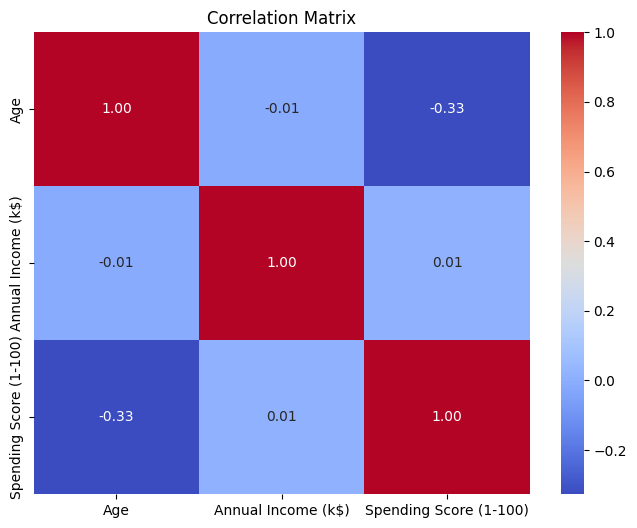

In [60]:
# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
# 🛠️ Step 6: Save the DataFrame as a CSV file
#output_path = "/mnt/c/Users/hmdkr/DE-Projects/mall-customers/data/mall_customers_analysis.csv"
#df.write.csv(output_path, header=True, mode="overwrite")
#print(f"✅ DataFrame saved to {output_path}")

In [17]:
# 🛠️ 5. Optional: Convert to Pandas for plotting
%pip install pandas

pandas_df = df.toPandas()

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Usi

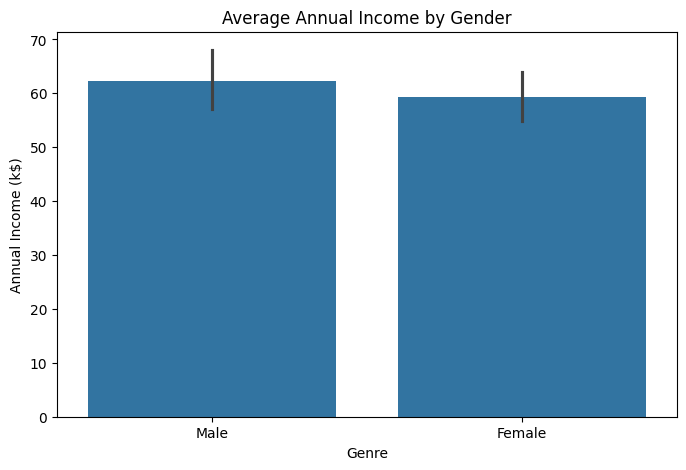

In [19]:
# Install matplotlib and seaborn if not already installed
%pip install matplotlib
%pip install seaborn

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data
plt.figure(figsize=(8,5))
sns.barplot(data=pandas_df, x="Genre", y="Annual Income (k$)")
plt.title("Average Annual Income by Gender")
plt.show()

## 🧠 Insights Summary

- Most customers fall into the middle range of spending scores.
- Income doesn't correlate directly with spending — some high spenders have moderate income.
- Segment opportunities:
  - **High Score + Low Income**: Loyal, budget-conscious
  - **High Score + High Income**: Premium target segment
